# AUC PLOT

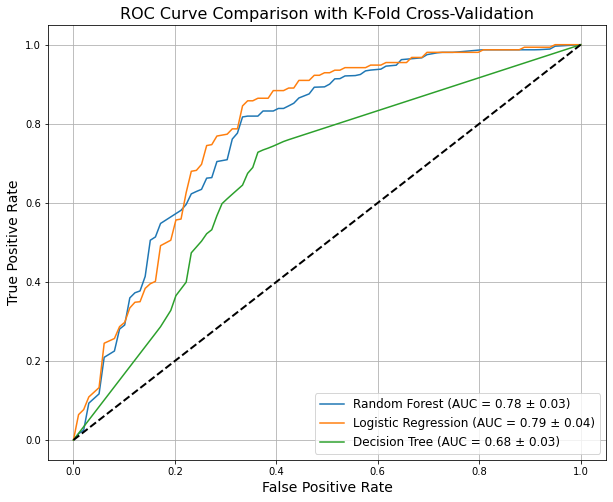

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import os

# Load the data
student_file = os.path.join("..", "data", "processed", "Merged_Final_File_Updated.xlsx")
df = pd.read_excel(student_file)

# Map dependent variable 'dropped out' to binary
df['dropped out'] = df['dropped out'].map({'no': 0, 'yes': 1})

# Define features and target
features = ['anl1 final grade', 'anl2 final grade', 'anl3 final grade', 'anl4 final grade', 'education_level']
target = 'dropped out'

X = df[features]
y = df[target]

# Define preprocessing for numerical and categorical features
numerical_features = ['anl1 final grade', 'anl2 final grade', 'anl3 final grade', 'anl4 final grade']
categorical_features = ['education_level']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1)),
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=60, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Stratified K-Fold setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize plot
plt.figure(figsize=(10, 8))

# Process each model
for name, model in models.items():
    tprs = []  # True positive rates
    mean_fpr = np.linspace(0, 1, 100)  # Interpolation points
    aucs = []  # Store AUCs

    # K-Fold cross-validation
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)  # Train the model
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_proba)  # Compute ROC curve
        tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate TPR
        tprs[-1][0] = 0.0  # Ensure it starts at 0
        aucs.append(auc(fpr, tpr))  # Compute AUC

    # Compute mean and std of TPR
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Ensure it ends at 1
    mean_auc = auc(mean_fpr, mean_tpr)  # Mean AUC
    std_auc = np.std(aucs)  # Std AUC

    # Plot mean ROC curve
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')


# Plot customization
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison with K-Fold Cross-Validation', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()


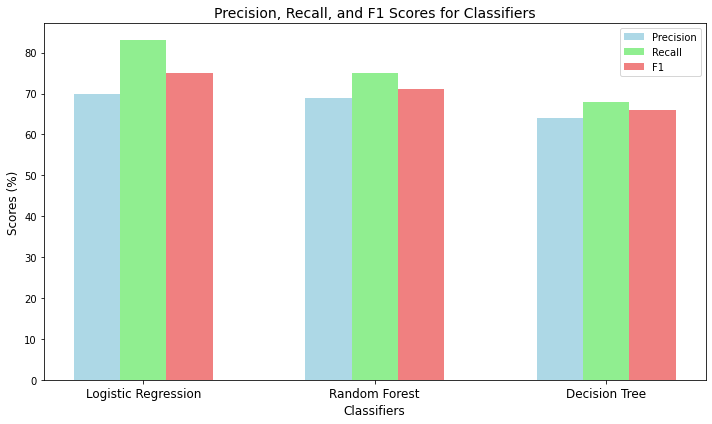

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Classifier names and their corresponding Precision, Recall, and F1 scores
classifiers = ['Logistic Regression', 'Random Forest', 'Decision Tree']
precision = [70, 69, 64]  # Precision (%)
recall = [83, 75, 68]  # Recall (%)
f1 = [75, 71, 66]  # F1 (%)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# X-axis locations for each group (Precision, Recall, F1)
x = np.arange(len(classifiers))

# Set bar width
width = 0.2

# Plot the bars for Precision, Recall, and F1 scores
ax.bar(x - width, precision, width, label='Precision', color='lightblue')
ax.bar(x, recall, width, label='Recall', color='lightgreen')
ax.bar(x + width, f1, width, label='F1', color='lightcoral')

# Labeling the plot
ax.set_xlabel('Classifiers', fontsize=12)
ax.set_ylabel('Scores (%)', fontsize=12)
ax.set_title('Precision, Recall, and F1 Scores for Classifiers', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classifiers, fontsize=12)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
